# Άσκηση 3

#### Παναγιώτης Τσιάβος 2396

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

### Event Handler

In [2]:
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print('Clicked on pixel: {},{}'.format(x,y))
        refPt.append([x,y])
        cv2.circle(img,(x,y),5,(0,255,0),-1)
        cv2.imshow("image", img)

### Ordering Points

Σε περίπτωση που ο χρήστης δεν έχει επιλέξει με τη επιθυμητή σειρα τα σημεία (top_left, top_right, bottom_right, bottom_left) καλούμε αυτή τη συνάρτηση για να τα ταξινομήσουμε σωστά.


Βασική ιδέα:  
Εφόσον η αρχική θέση μια εικόνας ειναι πάνω αριστερά μπορούμε να ταξινομήσουμε τα σημεία (pts) ως προς το πεδίο x για να βρούμε τα πιό αριστερά σημεία, αντίστοιχα και ως προς y.

Τα αριστερότερα σημεία (leftMost) θα είναι το top_left και bottom_left των συνολικων σημείων pts. Για να βρούμε πια από αυτα ειναι τι ταξινομούμε το leftMost ως προς το πεδίο y.  

Τα δεξιότερα σημεία (rightMost) θα είναι το top_right και bottom_right των συνολικων σημείων pts. Για να τα ξεχωρισούμε όμως δεν μας φτάνει μια επιπλεον ταξινομήση.  
<b>Η ιδέα του για να ξεχωρίσουμε τα δεξιότερα σημεία (rightMost)  βασίζεται πάνω στο βιβλίο Advances in Multimedia Information,Yo-Sung HoHyoung and Joong Kim (Geometry Coding, σελ.112)</b>
https://books.google.gr/books?id=CG72BwAAQBAJ&


Χρησιμοποιώντας ένα σημείο ως άγκυρα, μπορούμε να εφαρμόσουμε το Πυθαγόρειο θεώρημα και να υπολογίσουμε την Ευκλείδεια απόσταση μεταξύ υπόλοιπων σημείων. Με τον ορισμό ενός τριγώνου, η υποτείνουσα θα είναι η μεγαλύτερη πλευρά ενός ορθογώνιου τριγώνου.

Άρα αν θεωρήσουμε ως 'αγκυρα' (gate) το σημείο top_left το κάτω-δεξιό σημείο (bottom_right) θα πρέπει να έχει τη μεγαλύτερη ευκλείδια απόσταση.


$$\max_{1\leq i\leq k}(dist(C_i,x_j))$$

In [3]:
# Calculate the distance between points using Euclidean distance
def euclidean_distance(C,X):

    matrix = []
    for i in range(X.shape[0]):
        min_value = math.inf
        for j in range(C.shape[0]):
            distance = (np.dot(X[i] - C[j],X[i] - C[j])) ** .5
            min_value = min(min_value, distance)
        matrix.append(min_value)
    return np.array(matrix)

In [4]:
def clockwise_order(pts):
    pts = np.array(pts)

    # sort the points based on  x-coordinates
    x_sorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points
    leftMost = x_sorted[:2, :]
    rightMost = x_sorted[2:, :]

    #sort the left-most coordinates based on y-coordinates 
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    #Top_left, and bottom_right
    (tl, bl) = leftMost

    # Use top_left as an anchor, an calculate the Euclidean distance between the Top_left and RightMost
    D = euclidean_distance(tl[np.newaxis], rightMost)
#     print(D)
    # Bottom_right, and top_right
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    # return the coordinates
    return np.array([tl, tr, br, bl], dtype="float32")

### Γεωμετρικός μετασχηματισμός

Αρχικά υπολογίζουμε το μέγιστο εύρος (width) του τετραγώνου περικοπής η οποία ειναι η μέγιστη (Ευκλείδια) απόσταση μεταξυ δύο αποστάσεων καθώς και το μέγιστο ύψος (height).  
Εφόσον έχουμε βρει το μέγιστο εύρος και ύψος μπορούμε να υπολογίσουμε τα σημεία προόρισμου (x',y') για να αποκτήσουμε μια προβολή top-down-view της εικόνας.  
Καλούμε την συνάρτηση perspectiveTransform (διευκρίνηση παρακάτω) για να αποκτήσουμε τον 3 × 3 πίνακα που αντιστοιχεί στον προβολικό μετασχηματισμό και εφαρμόζουμε τον μετασχηματισμό με χρήσης της warpPerspective() από την opencv.  
Τέλος, επιστρέφουμε την μετασχηματισμένη εικόνα.

In [5]:
def transform(image, pts):
    # Order pts clockwise
    rect = clockwise_order(pts)
    (tl, tr, br, bl) = rect
    
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # compute destination Points based on formula
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    
    # compute the perspective transform matrix and then apply it
    M = perspective_transform_matrix(rect,dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    # return the warped image
    return warped

### Απόκτηση πίνακα προβολικού μετασχηματισμού (3x3)

Η παρακάτω συνάρτηση υπολογίζει τον πίνακα 3x3 ενός προοπτικού μετασχηματισμού :

<b>Ιδέα:</b>  
Έστω ότι το μοντέλο της κάμερας μπορεί να γραφτεί ως:  

$$X = Hx$$

όπου:  
- Χ: το διάνυσμα των συντεταγμένων top-down-view
- x: το διάνυσμα των συντεταγμένων του επιπέδου εικόνας
- H: ένας μετασχηματισμός

$$
\begin{bmatrix}
XY\\ 
YW\\ 
W
\end{bmatrix}
=
\begin{bmatrix}
a & b & c\\ 
d & e & f\\ 
g & h & 1
\end{bmatrix}
\begin{bmatrix}
x\\ 
y\\ 
1
\end{bmatrix}
$$

Παρατηρούμε ότι: 

$$W = gx + hy +1$$

Μπορούμε να αναγράψουμε την παραπάνω εξίσωση πινάκων ως:

$$
\begin{bmatrix}
X\\ 
Y\\ 
1
\end{bmatrix}
=
\frac{\begin{bmatrix}
a & b & c\\ 
d & e & f\\ 
g & h & 1
\end{bmatrix}
\begin{bmatrix}
x\\ 
y\\ 
1
\end{bmatrix}}
{[g,h,i]
\begin{bmatrix}
x\\ 
y\\ 
1
\end{bmatrix}}
$$

Με αλλα λόγια:

$$X = \frac{ax+by+c}{gx + hy +1}$$

$$Y = \frac{dx + ey + f}{gx + hy +1}$$

Πολλαπλασιάζοντας κάθε πλευρά με τον παρανομαστή:

$$X(gx + hy +1) = ax+by+c$$

$$Y(gx + hy +1) = dx + ey + f$$

Λύνοντας ως προς Χ και Υ και αντικαθηστοντας και τις κενές τιμες του μετασχηματισμου, καταληγουμε στο εξής:

$$X = ax+by+c -0d +0e +0f -Xxg - Xyh$$

$$Y = 0a + 0b + 0C +xd +yd +f -Yxg - Yyh$$

Παρατηρούμε ότι μπορεί να γραφτεί και ως το γινόμενο ενός πίνακα με ένα διάνυσμα για κάθε x,y:

$$
\begin{bmatrix}
x_1 & y_1 & 1 & 0 & 0 & 0 & -X_1x_1 & -X_1y_1\\ 
0 & 0 & 0 & x_1 & y_1 & 1 & -Y_1x_1 & -Y_1y_1\\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ 
. & . & . & . & . & . & . & .\\ 
. & . & . & . & . & . & . & .\\ 
x_n & y_n & 1 & 0 & 0 & 0 & -X_nx_n & -X_ny_n\\ 
0 & 0 & 0 & x_n & y_n & 1 & -Y_nx_n & -Y_ny_n\\ 
\end{bmatrix}
\begin{bmatrix}
a\\ 
b\\ 
c\\ 
d\\ 
e\\ 
f\\ 
g\\ 
h\\ 
\end{bmatrix}
=
\begin{bmatrix}
X_1\\ 
Y_1\\ 
X_2\\ 
Y_2\\ 
\vdots\\ 
X_n\\ 
Y_n\\ 
\end{bmatrix}
$$

Επομένος η τελική συνάρτηση ειναι της μορφής Ax=b και μπορεί να λυθεί με διάφορους τροπους, όπως:
- Χρήση γραμμικής άλγεβρας (inversing)
- Λύνοντας τις γραμμικές εξισώσεις.

1ος τρόπος (np.dot(np.linalg.inv(A.T * A) * A.T, B)):

$$ Ax= B $$

$$A^T Ax= A^TB$$

$$x = (A^TA)^{-1}A^TB$$

2ος τρόπος με χρήσης της numpy np.linalg.solve(A, B)

In [6]:
def perspective_transform_matrix(src, dst):

    matrix = []
    for (x, y), (X, Y) in zip(src, dst):
        matrix.extend([
            [x, y, 1, 0, 0, 0, -X * x, -X * y],
            [0, 0, 0, x, y, 1, -Y * x, -Y * y],
        ])

    A = np.matrix(matrix, dtype=np.float)
    B = np.array(dst).reshape(8)
    
#     res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    res = np.linalg.solve(A, B)
    
    # Don't forget to add the last value of projection matrix (is always 1)
    return np.append(np.array(res).reshape(8), 1).reshape((3, 3))

### Εκτέλεση

Αρχικά αναθέτουμε μια κενη λίστα (refPT) στην οποία θα αποθήκευουμε της συντεταγμένες περικοπής.  
Ανοίγουμε την επιθυμητή εικόνα με χρήση της openCV και αναθέτουμε εναν event listener.  
Ο χρήστης θα πρέπει να διαλέξει τις επιθυμητές γωνίες πατώντας (αριστερο κλικ) στην εικόνα, η σειρά επιλογης δεν παίζει ρόλο μιας και η συναρτηση order_points() τα ταξινομή στην επιθυμητή μας μορφή.  
Eφόσον o χρήστης έχει επιλέξει τις γωνίες θα πρέπει να κλεισει την εικόνα.  



In [7]:
refPt = []
img = cv2.imread("granma.jpg")
cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.imshow('image', img)


cv2.setMouseCallback("image", click_event)
cv2.waitKey(0)
cv2.destroyAllWindows()

if len(refPt) != 4:
        raise ValueError("There must be 4 source points, found: {}".format(len(refPt)))

        
warped = transform(img, refPt)

cv2.imshow("Warped", warped)
cv2.waitKey(0)
cv2.imwrite('warped_image.jpg',warped)

Clicked on pixel: 590,495
Clicked on pixel: 1496,489
Clicked on pixel: 1536,1090
Clicked on pixel: 326,949


True

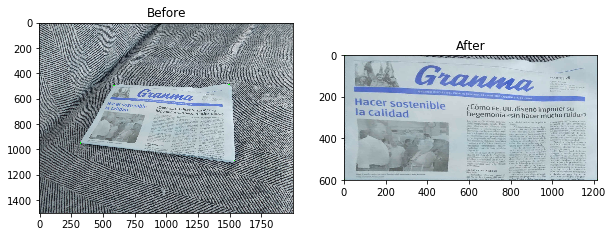

In [8]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.title("Before")
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title("After")
plt.imshow(warped)
plt.show()